In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn import metrics 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

## Data Preprocessing

Import the doctor fees xlsx file

In [2]:
doctor_fees = pd.read_excel('./data/doctors_fees_training_data.xlsx')

In [3]:
doctor_fees.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
0,"BHMS, MD - Homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100
1,"BAMS, MD - Ayurveda Medicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350
2,"MBBS, MS - Otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300
3,"BSc - Zoology, BAMS",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250
4,BAMS,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250


Checking for null and missing values

In [4]:
doctor_fees.isnull().sum()

Qualification            0
Experience               0
Rating                3302
Place                   25
Profile                  0
Miscellaneous_Info    2620
Fees                     0
dtype: int64

Get description of our dataset

In [5]:
doctor_fees.info()
doctor_fees.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5961 entries, 0 to 5960
Data columns (total 7 columns):
Qualification         5961 non-null object
Experience            5961 non-null object
Rating                2659 non-null object
Place                 5936 non-null object
Profile               5961 non-null object
Miscellaneous_Info    3341 non-null object
Fees                  5961 non-null int64
dtypes: int64(1), object(6)
memory usage: 326.1+ KB


,Fees
count,5961.000000
mean,307.944640
std,190.920373
min,5.000000
25%,150.000000
50%,300.000000
75%,500.000000
max,950.000000


Drop NaN / Missing rows

In [6]:
doctor_fees = doctor_fees.dropna()

Check distribution / count of the profiles

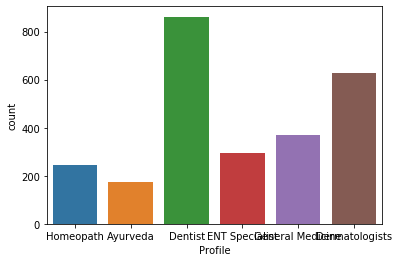

In [7]:
sns.countplot(doctor_fees['Profile'])

We have some nominal columns, such as qualification, profile, experience, and place. 
We need to perform one-hot and label encoding as well as some processing on the string values in certain columns and convert those to numerical values

In [8]:
ohe = OneHotEncoder(sparse=False)

In [9]:
lenc = LabelEncoder()

In [10]:
doctor_fees['Profile'] = lenc.fit_transform(doctor_fees['Profile'])

In [11]:
doctor_fees['Qualification'] = doctor_fees.apply(lambda x: x['Qualification'].split(',')[0], axis=1)

In [12]:
doctor_fees['Qualification'] = doctor_fees.apply(lambda x: x['Qualification'].split(' - ')[0], axis=1)

In [13]:
doctor_fees['Qualification'] = lenc.fit_transform(doctor_fees['Qualification'])

In [14]:
doctor_fees['Experience'] = doctor_fees.apply(lambda x: int(x['Experience'].split('years experience')[0]), axis=1)

In [15]:
doctor_fees['Rating'] =  doctor_fees.apply(lambda x: int(x['Rating'].split('%')[0]), axis=1)

In [16]:
doctor_fees['Place'] = ohe.fit_transform(doctor_fees[['Place']])

In [17]:
doctor_fees = doctor_fees.drop(['Miscellaneous_Info'], axis = 1)

In [18]:
doctor_fees.head()

,Qualification,Experience,Rating,Place,Profile,Fees
0,3,24,100,0.0,5,100
1,1,12,98,0.0,0,350
4,1,20,100,0.0,0,250
7,2,10,99,0.0,1,200
12,2,9,98,0.0,1,200


Lets see if there are some features in our data that are highly correlated

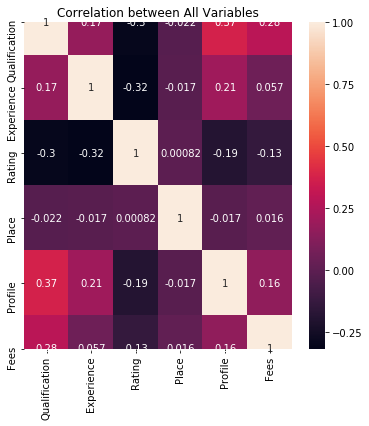

In [19]:
corr = doctor_fees.corr()
fig, ax = plt.subplots(figsize = (6, 6))
sns.heatmap(corr,ax = ax, annot= True)
ax.set_title('Correlation between All Variables')
plt.show()

Seems like qualification and fee, and profile and fee have high correlations - lets use qualification and fee for our models.

In [20]:
X = doctor_fees.drop(['Fees'], axis=1)
y = doctor_fees['Fees']

Split into training and testing data and perform scaling on the numerical values

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test.shape

(516, 5)

In [22]:
sc = StandardScaler()

In [23]:
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

## Models

Now we can create a couple of models and apply them to the scaled and pre-processed tipping data and compare their results.

In [24]:
models = []
models.append(('LinearRegression', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('RandomForest', RandomForestRegressor(n_estimators=10)))
models.append(('GradientBoost', GradientBoostingRegressor()))
models.append(('SVR', SVR(gamma='scale')))

In [25]:
for name,model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=2)
    results = model_selection.cross_val_score(model, X_train, y_train, cv= kfold, scoring = 'neg_mean_absolute_error')
    msg  = "%s: %f" % (name, -1*(results).mean())
    print(msg)

LinearRegression: 150.536275
Ridge: 150.538140
Lasso: 150.557771
DecisionTree: 188.451603
RandomForest: 165.023273
GradientBoost: 147.487609
SVR: 150.398349


The lower the negative mean absolute error, the better the model is fitting the data.

## Linear Regression

In [26]:
lr = LinearRegression(normalize=True)

In [27]:
# Reverse Scaling
# Convert to dataframe
# get total_bill column and reshape for plotting
# X_test_orig = sc.inverse_transform(X_test) #reverse scaling to plot 
X_df = pd.DataFrame(data=X_train, columns=['Qualification', 'Experience', 'Rating','Place','Profile'])
X_df_qual = X_df['Qualification'].values.reshape(-1,1)

X_test_df = pd.DataFrame(data=X_test, columns=['Qualification', 'Experience', 'Rating','Place','Profile'])
X_test_df_qual = X_test_df['Qualification'].values.reshape(-1,1)


In [28]:
lr.fit(X_df_qual, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [29]:
y_pred = lr.predict(X_test_df_qual)


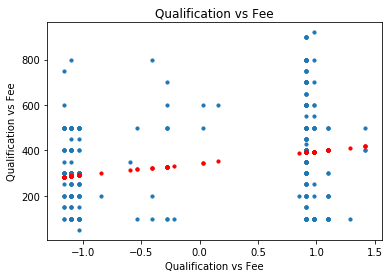

In [30]:
plt.scatter(X_test_df_qual, y_test, s=10)
# plt.plot(X_df_bill, y_pred, color='red')
plt.scatter(X_test_df_qual, y_pred, color='red', s=10)
# plt.plot(X_df_bill, y_pred, color='yellow')
plt.title('Qualification vs Fee')
plt.xlabel('Qualification vs Fee')
plt.ylabel('Qualification vs Fee')
plt.show()

Compare metrics

In [31]:
linear_rmse = (np.sqrt(mean_squared_error(y_test, y_pred))) #RMSE
linear_r2 = r2_score(y_test, y_pred) #R2

In [32]:
linear_rmse

187.0978727089391

In [33]:
linear_r2

0.10731401385166073

## Ridge Regression

In [34]:
ridge = Ridge(normalize=True)

In [35]:
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [36]:
ridge_y_pred = ridge.predict(X_test)

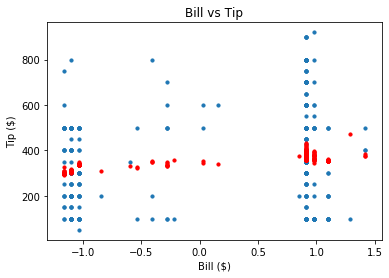

In [37]:
# Blue = Train; Red = Test
# Green = X_train + Predict(X_train)
# Yellow = X_test + y_pred
plt.scatter(X_test_df_qual, y_test, s=10)
# plt.plot(X_train_df_bill, ridge.predict(X_train), color='green')
plt.scatter(X_test_df_qual, ridge_y_pred, color='red', s=10)
# plt.scatter(X_df_bill['total_bill'].values.reshape(-1,1), ridge_y_pred, color='red')
plt.title('Bill vs Tip')
plt.xlabel('Bill ($)')
plt.ylabel('Tip ($)')
plt.show()

In [38]:
ridge_rmse = (np.sqrt(mean_squared_error(y_test, ridge_y_pred))) #RMSE
ridge_r2 = r2_score(y_test, ridge_y_pred) #R2

In [39]:
ridge_rmse

190.5421082865767

In [40]:
ridge_r2

0.07414505546912298

## Lasso Regression

In [41]:
lasso = Lasso(alpha=0.01, fit_intercept=True, normalize=True)

In [42]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [43]:
lasso_y_pred = lasso.predict(X_test)

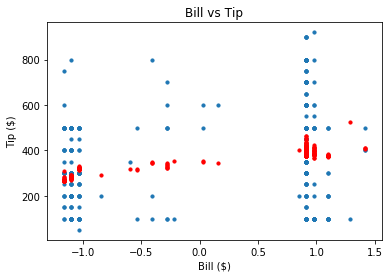

In [44]:
# Blue = Train; Red = Test
# Green = X_train + Predict(X_train)
# Yellow = X_test + y_pred
plt.scatter(X_test_df_qual, y_test, s=10)
# plt.plot(X_df_bill, lasso.predict(X_test), color='green')
plt.scatter(X_test_df_qual, lasso_y_pred, color='red', s=10)
# plt.plot(X_df_bill, lasso_y_pred, color='yellow')
plt.title('Bill vs Tip')
plt.xlabel('Bill ($)')
plt.ylabel('Tip ($)')
plt.show()

In [45]:
lasso_rmse = (np.sqrt(mean_squared_error(y_test, lasso_y_pred))) #RMSE
lasso_r2 = r2_score(y_test, lasso_y_pred) #R2

In [46]:
lasso_rmse

187.65777109145324

In [47]:
lasso_r2

0.10196321761830174

## Decision Tree

In [48]:
decision = DecisionTreeRegressor(criterion='mse', max_depth=5, max_leaf_nodes=5)

In [49]:
decision.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=5, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [50]:
decision_y_pred = decision.predict(X_test)

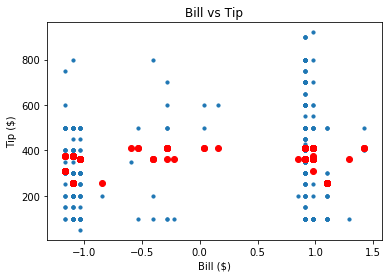

In [51]:
# Blue = Train; Red = Test
# Green = X_train + Predict(X_train)
# Yellow = X_test + y_pred
plt.scatter(X_test_df_qual, y_test, s=10)
# plt.plot(X_train_df_bill, decision.predict(X_train), color='green')
# plt.scatter(X_df_bill, decision_y_pred, color='red', s=10)
plt.scatter(X_test_df_qual, decision_y_pred, color='red')
plt.title('Bill vs Tip')
plt.xlabel('Bill ($)')
plt.ylabel('Tip ($)')
plt.show()

In [75]:
decision_rmse = (np.sqrt(mean_squared_error(y_test, decision_y_pred))) #RMSE
decision_r2 = r2_score(y_test, decision_y_pred) #R2

In [76]:
decision_rmse

181.9613932942034

In [77]:
decision_r2

0.15565579895201154

## Random Forest

In [52]:
model = RandomForestRegressor(n_estimators=50, max_depth=2, max_features=5)

In [53]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [54]:
forest_y_pred = model.predict(X_test)

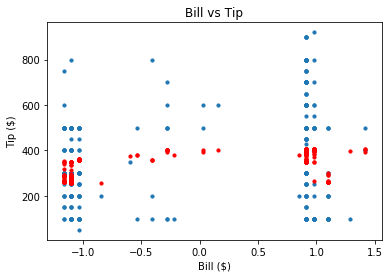

In [55]:
# Blue = Train; Red = Test
# Green = X_train + Predict(X_train)
# Yellow = X_test + y_pred
plt.scatter(X_test_df_qual, y_test, s=10)
# plt.plot(X_train_df_bill, decision.predict(X_train), color='green')
plt.scatter(X_test_df_qual, forest_y_pred, color='red', s=10)
# plt.plot(X_df_bill, decision_y_pred, color='yellow')
plt.title('Bill vs Tip')
plt.xlabel('Bill ($)')
plt.ylabel('Tip ($)')
plt.show()

In [56]:
forest_rmse = (np.sqrt(mean_squared_error(y_test, forest_y_pred))) #RMSE
forest_r2 = r2_score(y_test, forest_y_pred) #R2

In [57]:
forest_rmse

182.52114775691823

In [58]:
forest_r2

0.15045302074196087

## Gradient Boosting

In [59]:
grad = GradientBoostingRegressor(n_estimators=10, learning_rate=0.1, max_depth=5)

In [60]:
grad.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [61]:
grad_y_pred = grad.predict(X_test)

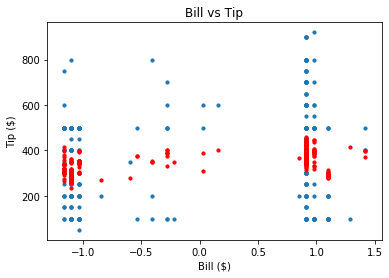

In [62]:
# Blue = Train; Red = Test
# Green = X_train + Predict(X_train)
# Yellow = X_test + y_pred
plt.scatter(X_test_df_qual, y_test, s=10)
# plt.plot(X_train_df_bill, decision.predict(X_train), color='green')
plt.scatter(X_test_df_qual, grad_y_pred, color='red', s=10)
# plt.plot(X_df_bill, decision_y_pred, color='yellow')
plt.title('Bill vs Tip')
plt.xlabel('Bill ($)')
plt.ylabel('Tip ($)')
plt.show()


In [63]:
grad_rmse = (np.sqrt(mean_squared_error(y_test, grad_y_pred))) #RMSE
grad_r2 = r2_score(y_test, grad_y_pred) #R2

In [64]:
grad_rmse

183.66368377718578

In [65]:
grad_r2

0.1397838351663434

## Support Vector Regression

In [66]:
svr = SVR(gamma='scale')

In [67]:
svr.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [68]:
svr_y_pred = svr.predict(X_test)

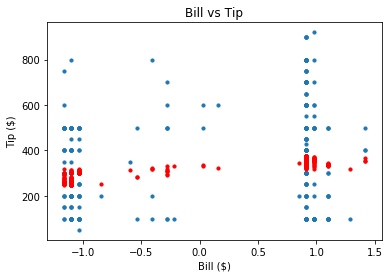

In [69]:
# Blue = Train; Red = Test
# Green = X_train + Predict(X_train)
# Yellow = X_test + y_pred
plt.scatter(X_test_df_qual, y_test, s=10)
# plt.plot(X_train_df_bill, decision.predict(X_train), color='green')
plt.scatter(X_test_df_qual, svr_y_pred, color='red', s=10)
# plt.plot(X_df_bill, decision_y_pred, color='yellow')
plt.title('Bill vs Tip')
plt.xlabel('Bill ($)')
plt.ylabel('Tip ($)')
plt.show()

In [70]:
svr_rmse = (np.sqrt(mean_squared_error(y_test, svr_y_pred))) #RMSE
svr_r2 = r2_score(y_test, svr_y_pred) #R2

In [71]:
grad_rmse

183.66368377718578

In [72]:
grad_r2

0.1397838351663434